In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['demoId', 'roundNum'])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,demoId,roundNum
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 101 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(1), uint8(10)
memory usage: 5.0+ GB


In [6]:
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()
y

0          0
1          0
2          0
3          0
4          0
          ..
7464293    1
7464294    1
7464295    1
7464296    1
7464297    1
Name: winningSideCT, Length: 7464298, dtype: int32

## Podział

In [7]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
np.random.seed(25)
samples_indexes = [values[np.random.randint(1, values.size)]
                  for key, values in demo_indexes.items()]
len(samples_indexes)

41074

In [8]:
X = df.drop(['demoId', 'roundNum'], axis='columns').iloc[samples_indexes]
y = y.iloc[samples_indexes]
X.shape, y.shape

((41074, 99), (41074,))

In [9]:
y.value_counts()

1    22158
0    18916
Name: winningSideCT, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1
X_train.shape, X_val.shape, X_test.shape

((28751, 99), (4108, 99), (8215, 99))

In [11]:
cols = X_train.columns.tolist()
scaler = StandardScaler()
norm_train = scaler.fit_transform(X_train)
norm_valid = scaler.transform(X_val)
norm_test = scaler.transform(X_test)

In [12]:
os.makedirs("model_deep", exist_ok=True)

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/multi_layer.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/perceptron_log.csv", separator=',', append=True
)

In [15]:
model = Sequential()
model.add(InputLayer(input_shape=(norm_train.shape[-1])))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(x=norm_train,
                    y=y_train,
                    batch_size=2048,
                    epochs=1000,
                    validation_data=(norm_valid, y_val),
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/1000
15/15 [==============================] - 2s 14ms/step - loss: 1.7004 - binary_accuracy: 0.6512 - auc_1: 0.7132 - val_loss: 1.4756 - val_binary_accuracy: 0.7541 - val_auc_1: 0.8441
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 2/1000
15/15 [==============================] - 0s 7ms/step - loss: 1.3847 - binary_accuracy: 0.7616 - auc_1: 0.8552 - val_loss: 1.2735 - val_binary_accuracy: 0.7700 - val_auc_1: 0.8643
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 3/1000
15/15 [==============================] - 0s 7ms/step - loss: 1.2005 - binary_accuracy: 0.7724 - auc_1: 0.8677 - val_loss: 1.1134 - val_binary_accuracy: 0.7724 - val_auc_1: 0.8696
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 4/1000
15/15 [==============================] - 0s 8ms/step - loss: 1.0528 - binary_accuracy: 0.7756 - auc_1: 0.8725 - val_loss: 0.9825 - val_binary_accuracy: 0.7770 - val_auc_1: 0.8722
INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: models/model.tf\assets


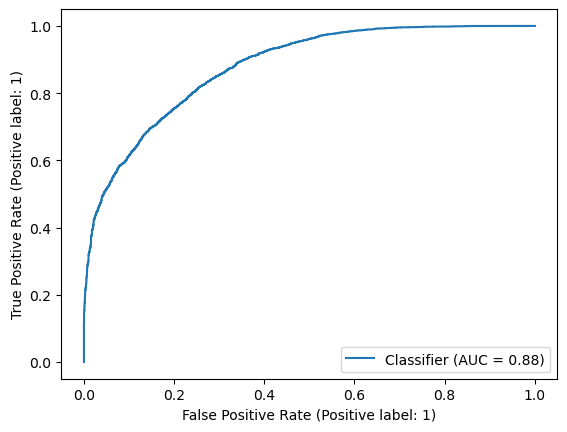

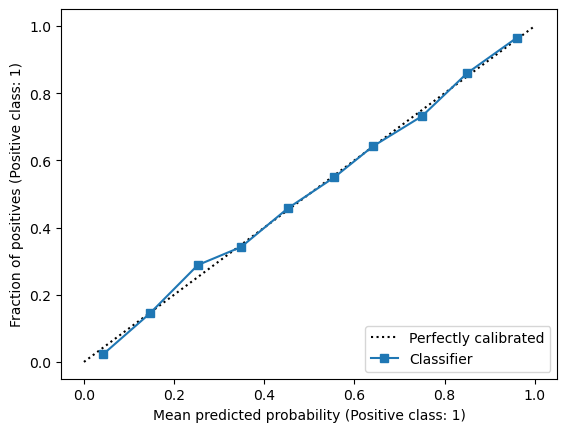

In [16]:
run_name = "Multi Layer Perceptron - ESTA"
additional_description = "Multi Layer Perceptron"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)

        y_proba = model.predict(norm_test)
        y_true = y_test
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [17]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [19]:
test_set = test_df.drop("filename", axis="columns")
test_set = scaler.fit_transform(test_set)
test_set.shape

(620392, 99)

In [22]:
results = []
y_true = test_y
y_pred = model.predict(test_set)
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.47458299565974393,
 'LogLoss (future)': 0.47630394417800087,
 'LogLoss (past)': 0.4729783169430419,
 'AUC-ROC (all)': 0.8492606942087579,
 'AUC-ROC (future)': 0.85204551326014,
 'AUC-ROC (past)': 0.8458100825149664}

# Większy sampling

## Podział

In [23]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
np.random.seed(25)
how_many = 10
samples_indexes = {key: [values[np.random.randint(1, values.size)]
                   for i in range(how_many)]
                      for key, values in demo_indexes.items()}
len(samples_indexes)

41074

In [24]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
test_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i not in train_ind:
        test_indexes = np.concatenate((test_indexes, samples_indexes[key]))

test_indexes.shape

(82150,)

In [25]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(train_ind, size=int(0.875*train_ind.size), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((287510,), (123230,))

In [26]:
X = df.drop(['demoId', 'roundNum'], axis='columns')
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()

In [27]:
y.value_counts()

1    3875902
0    3588396
Name: winningSideCT, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], y.iloc[train_indexes], y.iloc[test_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape, X_test.shape

((287510, 99), (123230, 99), (82150, 99))

In [29]:
cols = X_train.columns.tolist()
scaler = StandardScaler()
norm_train = scaler.fit_transform(X_train)
norm_valid = scaler.transform(X_val)
norm_test = scaler.transform(X_test)

In [30]:
os.makedirs("model_deep", exist_ok=True)

In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/multi_layer.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/perceptron_log.csv", separator=',', append=True
)

In [32]:
model = Sequential()
model.add(InputLayer(input_shape=(norm_train.shape[-1])))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(x=norm_train,
                    y=y_train,
                    batch_size=2048,
                    epochs=1000,
                    validation_data=(norm_valid, y_val),
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/1000
141/141 [==============================] - 1s 7ms/step - loss: 0.9343 - binary_accuracy: 0.7711 - auc_2: 0.8661 - val_loss: 0.5565 - val_binary_accuracy: 0.7818 - val_auc_2: 0.8758
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 2/1000
141/141 [==============================] - 1s 5ms/step - loss: 0.4847 - binary_accuracy: 0.7842 - auc_2: 0.8803 - val_loss: 0.4615 - val_binary_accuracy: 0.7818 - val_auc_2: 0.8769
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 3/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.4511 - binary_accuracy: 0.7841 - auc_2: 0.8803 - val_loss: 0.4550 - val_binary_accuracy: 0.7797 - val_auc_2: 0.8760
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 4/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.4474 - binary_accuracy: 0.7840 - auc_2: 0.8801 - val_loss: 0.4517 - val_binary_accuracy: 0.7812 - val_auc_2: 0.8770
INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: models/model.tf\assets


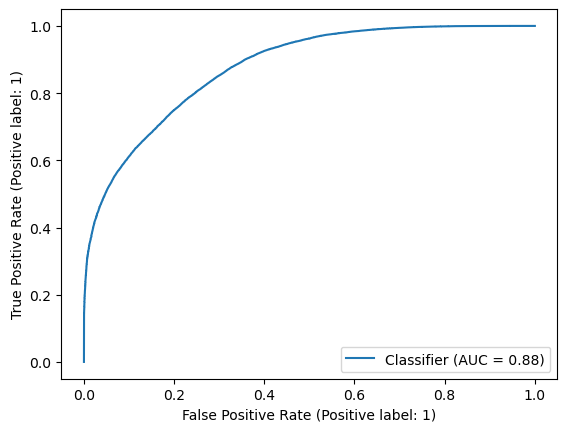

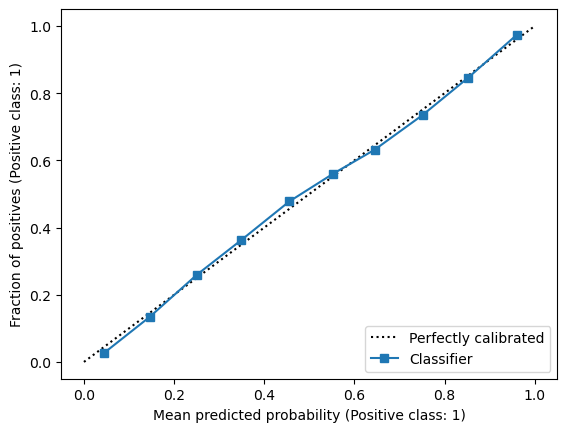

In [33]:
run_name = "Multi Layer Perceptron - ESTA 10 samples"
additional_description = "Multi Layer Perceptron"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)

        y_proba = model.predict(norm_test)
        y_true = y_test
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [34]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [35]:
test_set = test_df.drop("filename", axis="columns")
test_set = scaler.fit_transform(test_set)
test_set.shape

(620392, 99)

In [36]:
results = []
y_true = test_y
y_pred = model.predict(test_set)
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.47369623971313723,
 'LogLoss (future)': 0.4734274935436232,
 'LogLoss (past)': 0.47394682899796436,
 'AUC-ROC (all)': 0.8495413314726281,
 'AUC-ROC (future)': 0.8531864090839258,
 'AUC-ROC (past)': 0.8452586175413814}

# All dataset

In [37]:
groupped = df.groupby(['demoId'])
samples_indexes = groupped.indices
len(samples_indexes)

1558

In [38]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
test_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i not in train_ind:
        test_indexes = np.concatenate((test_indexes, samples_indexes[key]))

test_indexes.shape

(1500668,)

In [39]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(train_ind, size=int(0.875*train_ind.size), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((5226658,), (2237640,))

In [40]:
X = df.drop(['demoId', 'roundNum'], axis='columns')
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()

In [41]:
y.value_counts()

1    3875902
0    3588396
Name: winningSideCT, dtype: int64

In [42]:
X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], y.iloc[train_indexes], y.iloc[test_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape, X_test.shape

((5226658, 99), (2237640, 99), (1500668, 99))

In [43]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.519761
 0    0.480239
 Name: winningSideCT, dtype: float64,
 1    0.518086
 0    0.481914
 Name: winningSideCT, dtype: float64,
 1    0.511272
 0    0.488728
 Name: winningSideCT, dtype: float64)

In [44]:
cols = X_train.columns.tolist()
scaler = StandardScaler()
norm_train = scaler.fit_transform(X_train)
norm_valid = scaler.transform(X_val)
norm_test = scaler.transform(X_test)

In [45]:
os.makedirs("model_deep", exist_ok=True)

In [46]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/multi_layer.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/perceptron_log.csv", separator=',', append=True
)

In [47]:
model = Sequential()
model.add(InputLayer(input_shape=(norm_train.shape[-1])))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(x=norm_train,
                    y=y_train,
                    batch_size=10000,
                    epochs=1000,
                    validation_data=(norm_valid, y_val),
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/1000
523/523 [==============================] - 3s 5ms/step - loss: 0.6166 - binary_accuracy: 0.7605 - auc_3: 0.8582 - val_loss: 0.4756 - val_binary_accuracy: 0.7635 - val_auc_3: 0.8608
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 2/1000
523/523 [==============================] - 2s 5ms/step - loss: 0.4718 - binary_accuracy: 0.7639 - auc_3: 0.8623 - val_loss: 0.4743 - val_binary_accuracy: 0.7624 - val_auc_3: 0.8604
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 3/1000
523/523 [==============================] - 2s 5ms/step - loss: 0.4713 - binary_accuracy: 0.7635 - auc_3: 0.8620 - val_loss: 0.4744 - val_binary_accuracy: 0.7620 - val_auc_3: 0.8598
Epoch 4/1000
523/523 [==============================] - 2s 4ms/step - loss: 0.4711 - binary_accuracy: 0.7634 - auc_3: 0.8619 - val_loss: 0.4738 - val_binary_accuracy: 0.7626 - val_auc_3: 0.8604
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 5/1000
523/523

INFO:tensorflow:Assets written to: models/model.tf\assets


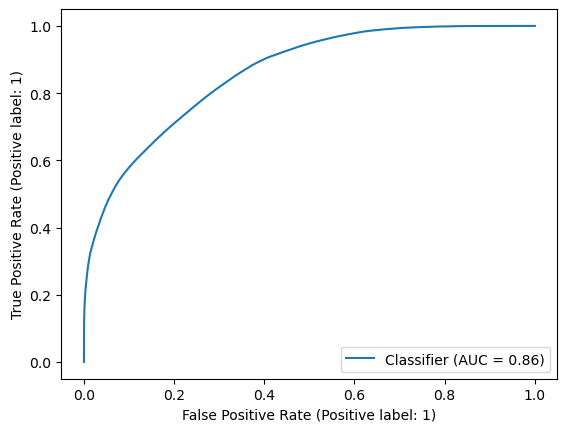

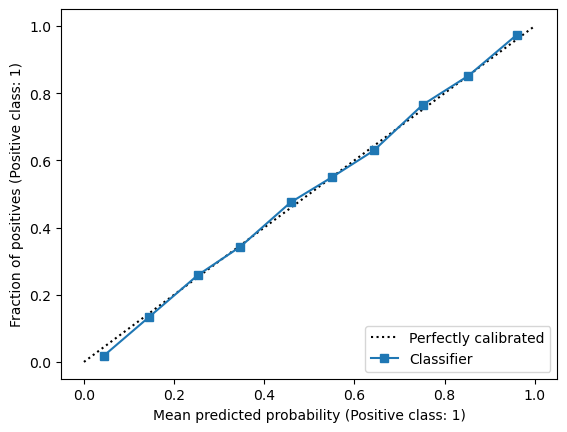

In [48]:
run_name = "Multi Layer Perceptron - ESTA All Dataset"
additional_description = "Multi Layer Perceptron"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)

        y_proba = model.predict(norm_test)
        y_true = y_test
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [51]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [52]:
test_set = test_df.drop("filename", axis="columns")
test_set = scaler.fit_transform(test_set)
test_set.shape

(620392, 99)

In [53]:
results = []
y_true = test_y
y_pred = model.predict(test_set)
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.4691799452488191,
 'LogLoss (future)': 0.4707177326200744,
 'LogLoss (past)': 0.46774605304385886,
 'AUC-ROC (all)': 0.8492394022138687,
 'AUC-ROC (future)': 0.8504051707752497,
 'AUC-ROC (past)': 0.8474622206481062}